# 02: Geoprocessing


## imports


In [1]:
%matplotlib ipympl

import pyogrio as ogr
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap

# done
# spatial join
# buildings to tax lots
# buildings in 3d with lonboard
# dissolve tax lot by lu or by owner

# not done
# union tax lots and sidewalk to get blocks in total
# intersect to show non-building area
# calculate soft site potential based on FAR, lot size, building class

In [2]:
cb_307 = ogr.read_dataframe(
    "../Data/nyc_mappluto_24v1_1_shp/mappluto_ogr.fgb", where="CD = 307"
)

<Axes: >

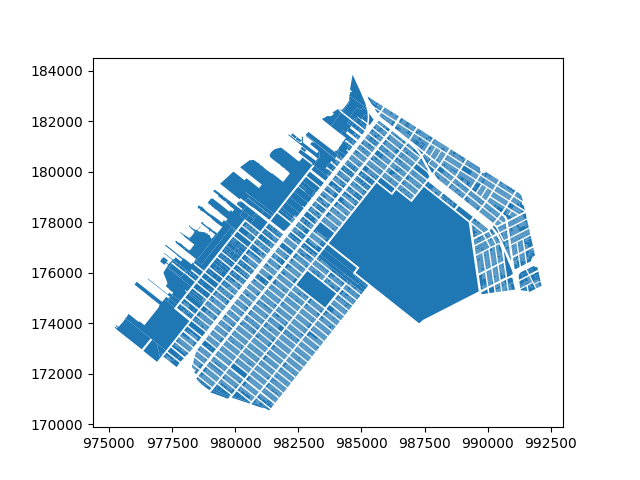

In [3]:
cb_307.plot()

In [4]:
# get maximum bounding geometry for all tax lots
bounds = cb_307.total_bounds

In [5]:
bounds_poly = gpd.GeoSeries(
    Polygon(
        [
            [bounds[0], bounds[1]],
            [bounds[0], bounds[3]],
            [bounds[2], bounds[3]],
            [bounds[2], bounds[1]],
            [bounds[0], bounds[1]],
        ]
    )
)

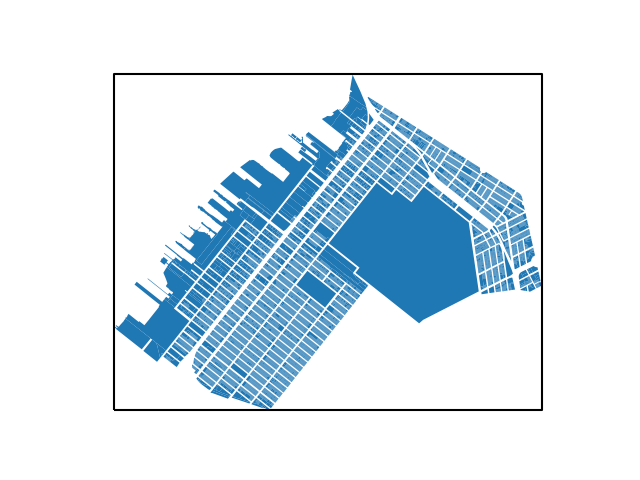

In [6]:
ax = cb_307.plot()
bounds_poly.boundary.plot(ax=ax, color="black").set_axis_off()

In [7]:
bounds_poly

0    POLYGON ((975222.902 170552.422, 975222.902 18...
dtype: geometry

In [8]:
bounds_poly.crs = cb_307.crs

In [9]:
bounds_poly.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## reproject


In [10]:
bounds_poly_wgs84 = bounds_poly.to_crs("EPSG:4326")

In [11]:
cb_307_bldgs = ogr.read_dataframe(
    "../Data/Building Footprints.geojson",
    mask=bounds_poly_wgs84[0],
)

<Axes: >

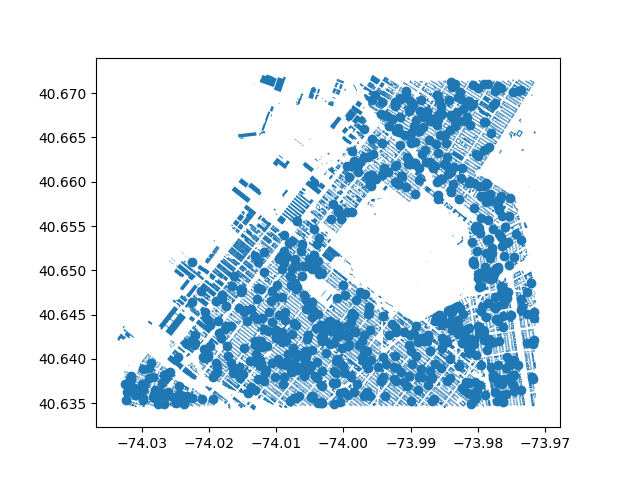

In [12]:
cb_307_bldgs.plot()

In [13]:
cb_307_bldgs = cb_307_bldgs[cb_307_bldgs.geometry.type != "Point"]

<Axes: >

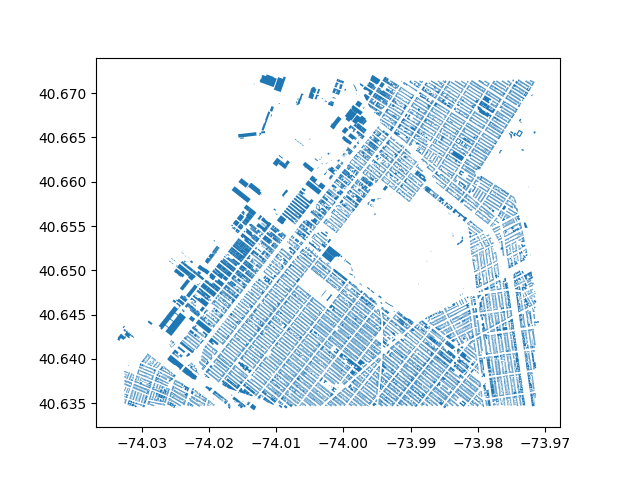

In [14]:
cb_307_bldgs.plot()

In [15]:
cb_307_bldgs = cb_307_bldgs.to_crs(cb_307.crs)

## spatial join


In [16]:
cb_307_bldgs["rep_pt"] = cb_307_bldgs.representative_point()
cb_307_bldgs.set_geometry("rep_pt", inplace=True)

In [17]:
cb_307_bldgs.base_bbl.nunique(), cb_307_bldgs.shape[0], cb_307_bldgs.globalid.nunique()

(26358, 30110, 30110)

In [18]:
cb_307_bldgs

name    base_bbl shape_area   heightroof  mpluto_bbl cnstrct_yr  \
0      None  3008130054        0.0        31.05  3008130054       1901   
1      None  3010120038        0.0        42.44  3010120038       1921   
2      None  3053130127        0.0  26.38239517  3053130127       1940   
3      None  3058710090        0.0        24.71  3058710090       1920   
4      None  3058850095        0.0        26.79  3058850095       1925   
...     ...         ...        ...          ...         ...        ...   
30105  None  3055910017        0.0         60.0  3055917508       2008   
30106  None  3006390016        0.0         None  3006390016       2021   
30107  None  3007280036        0.0         60.0  3007280036       2024   
30108  None  3010510039        0.0        120.0  3010510039       2023   
30109  None  3008500069        0.0         36.0  3008500069       2024   

                                     globalid   lststatype feat_code  \
0      {C2B6150A-AA05-4865-B836-9DFA5C153E9C}  Constructed      2100   
1      {65E24ABD-485B-4B01-B70E-5ACA0E221B53}  Constructed      2100   
2      {454D03AE-5F41-4886-A5C5-74DD122005EF}  Constructed      2100   
3      {F02017F9-C56E-4793-96D1-03741F2569AC}  Constructed      2100   
4      {D97E7A81-466F-47F7-9159-D52052EC7129}  Constructed      2100   
...                                       ...          ...       ...   
30105  {F565CBEB-73A0-4C8B-8ACF-D7E26DEDFB03}  Constructed      2100   
30106  {019343C0-3AC3-47DE-9C68-0011F8B5B7AD}  Constructed      2100   
30107  {041C01B4-5A94-46C4-A3BB-0457C706C8BC}  Constructed      2100   
30108  {0007187C-0E44-4204-AFE4-F9C3FC0C1DA8}  Constructed      2100   
30109  {80FE3F5F-B642-4006-A6AE-88B3A19C4756}  Constructed      5100   

      groundelev  geomsource      bin lstmoddate doitt_id shape_len  \
0             48  Photogramm  3014166 2017-08-22   392052       0.0   
1            115  Photogramm  3022371 2017-08-22   743038       0.0   
2             57  Photogramm  3123939 2017-08-22   785686       0.0   
3             73  Photogramm  3145644 2017-08-22   560761       0.0   
4             68  Photogramm  3146300 2017-08-22   541427       0.0   
...          ...         ...      ...        ...      ...       ...   
30105         74  Other (Man  3394074 2024-05-29  1100472       0.0   
30106         18  Other (Man  3009227 2024-05-03  1294399       0.0   
30107         63  Other (Man  3426350 2024-06-20  1302168       0.0   
30108         46  Other (Man  3024085 2024-06-18  1302163       0.0   
30109         89  Other (Man  3015911 2024-07-09  1302226       0.0   

                                                geometry  \
0      MULTIPOLYGON (((979424.884 174653.762, 979393....   
1      MULTIPOLYGON (((989250.122 182249.393, 989226....   
2      MULTIPOLYGON (((989342.250 173309.206, 989328....   
3      MULTIPOLYGON (((976372.261 170905.430, 976404....   
4      MULTIPOLYGON (((975991.817 170852.230, 975985....   
...                                                  ...   
30105  MULTIPOLYGON (((986063.897 173535.911, 986025....   
30106  MULTIPOLYGON (((985148.458 181241.335, 985161....   
30107  MULTIPOLYGON (((981766.623 176163.648, 981761....   
30108  MULTIPOLYGON (((986145.791 181865.976, 986188....   
30109  MULTIPOLYGON (((981570.342 171607.402, 981539....   

                              rep_pt  
0      POINT (979402.531 174638.900)  
1      POINT (989230.470 182235.219)  
2      POINT (989345.270 173325.920)  
3      POINT (976382.124 170892.831)  
4      POINT (975969.477 170848.875)  
...                              ...  
30105  POINT (986034.911 173520.284)  
30106  POINT (985116.244 181187.492)  
30107  POINT (981725.644 176235.773)  
30108  POINT (986220.175 181831.511)  
30109  POINT (981570.489 171623.022)  

[30110 rows x 17 columns]

In [19]:
## spatial join buildings to tax lots based on building representative point
bldgs_w_lot = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin(
    cb_307, how="inner", op="within"
)

/opt/homebrew/Caskroom/miniforge/base/envs/map2/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
bldgs_w_lot_nearest = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin_nearest(
    cb_307, how="left", distance_col="distance"
)

<Axes: >

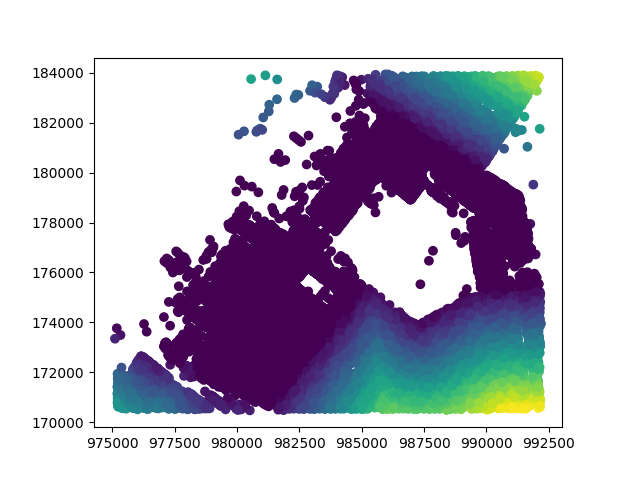

In [21]:
bldgs_w_lot_nearest.plot("distance")

<Axes: >

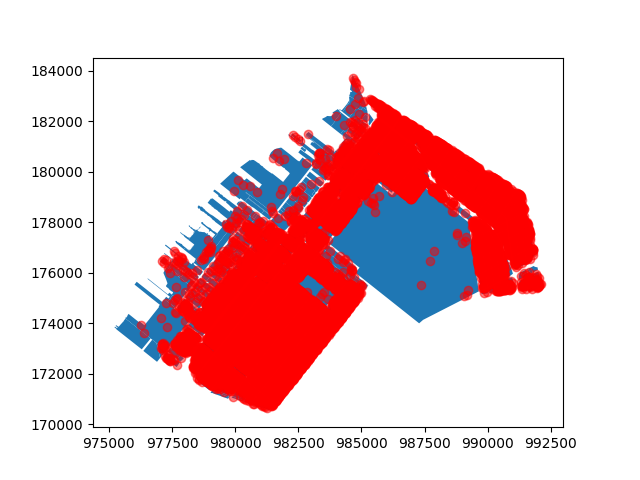

In [22]:
ax = cb_307.plot()
bldgs_w_lot.plot(ax=ax, color="red", alpha=0.5)

In [23]:
## drop cases where there is no match (i.e. no tax lot for buildings)


In [24]:
# now, join back to original building footprints
bldgs_w_lot = bldgs_w_lot.drop(columns=["rep_pt"]).merge(
    cb_307_bldgs, on="globalid", how="left"
)

In [25]:
bldgs_w_lot_gdf = gpd.GeoDataFrame(bldgs_w_lot, geometry="geometry")

In [26]:
cmap = {
    "One & Two Family Buildings": "#ff0000",
    "Multi-Family Walk-Up Buildings": "#00ff00",
    "Multi-Family Elevator Buildings": "#0000ff",
    "Mixed Residential & Commercial Buildings": "#ff00ff",
    "Commercial & Office Buildings": "#00ffff",
    "Industrial & Manufacturing": "#ffff00",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#800000",
    "Open Space & Outdoor Recreation": "#008000",
    "Parking Facilities": "#000080",
    "Vacant Land": "#800080",
    "Unknown": "#000000",
}

In [27]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

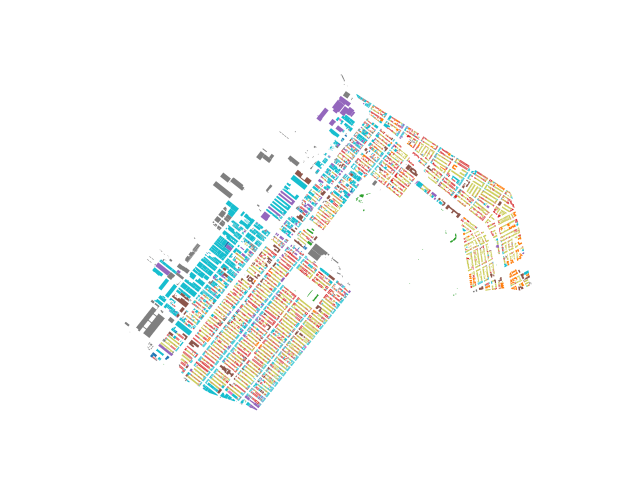

In [28]:
bldgs_w_lot_gdf["color"] = bldgs_w_lot_gdf["LandUse"].map(cmap)
bldgs_w_lot_gdf.plot(column="color", legend=False).set_axis_off()

In [29]:
bldgs_w_lot_gdf.fillna({"LandUse": "Unknown"}, inplace=True)

In [30]:
cmap_rgb

{'One & Two Family Buildings': [255, 0, 0],
 'Multi-Family Walk-Up Buildings': [0, 255, 0],
 'Multi-Family Elevator Buildings': [0, 0, 255],
 'Mixed Residential & Commercial Buildings': [255, 0, 255],
 'Commercial & Office Buildings': [0, 255, 255],
 'Industrial & Manufacturing': [255, 255, 0],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [128, 0, 0],
 'Open Space & Outdoor Recreation': [0, 128, 0],
 'Parking Facilities': [0, 0, 128],
 'Vacant Land': [128, 0, 128],
 'Unknown': [0, 0, 0]}

In [31]:
# make a lonboard plot with color based on land use and height based on number of floors
heights = bldgs_w_lot_gdf["heightroof"].astype(float).to_numpy()
bldgs_layer = PolygonLayer.from_geopandas(
    bldgs_w_lot_gdf[["geometry", "LandUse"]],
    get_fill_color=apply_categorical_cmap(bldgs_w_lot_gdf["LandUse"], cmap=cmap_rgb),
    extruded=True,
    get_elevation=heights,
)

m = Map(
    [bldgs_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)
m

/opt/homebrew/Caskroom/miniforge/base/envs/map2/lib/python3.11/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x1774f0460>
[
  31.05…

## attribute join


... sometimes it makes more sense to join based on attributes rather than spatial relationships. This is one of those cases.


In [32]:
cb_307_bldgs.mpluto_bbl.nunique(), cb_307.shape

(26321, (13284, 98))

In [33]:
cb_307.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [34]:
cb_307_bldgs.mpluto_bbl.dtype, cb_307.BBL.dtype

(dtype('O'), dtype('float64'))

In [35]:
cb_307_bldgs["mpluto_bbl"] = cb_307_bldgs["mpluto_bbl"].astype(float)

In [36]:
bldgs_w_lot_attrib = cb_307_bldgs.merge(
    cb_307, left_on="mpluto_bbl", right_on="BBL", how="inner"
)

In [37]:
# assert bldgs_w_lot_attrib.shape == bldgs_w_lot_gdf.shape
bldgs_w_lot_attrib.shape == bldgs_w_lot_gdf.shape

False

<Axes: >

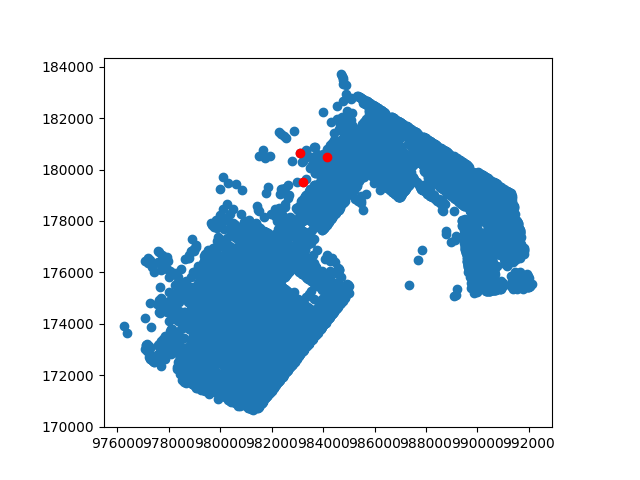

In [38]:
# find the globalid of the buildings in bldgs_w_lot_attrib that are not in bldgs_w_lot_gdf
ax = bldgs_w_lot_attrib.plot()
bldgs_w_lot_attrib[~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)].plot(
    ax=ax, color="red"
)

In [39]:
missing_buildings = bldgs_w_lot_attrib[
    ~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)
].globalid.unique()

In [40]:
bldgs_w_lot_attrib["geometry"] = bldgs_w_lot_attrib["geometry_x"]

In [41]:
bldgs_w_lot_attrib.set_geometry("geometry", inplace=True)

### investigate- what's going on??


In [42]:
# make a lonboard plot with color based on land use and height based on number of floors

missing_bldgs = bldgs_w_lot_attrib[bldgs_w_lot_attrib.globalid.isin(missing_buildings)]

heights_missing = missing_bldgs["heightroof"].astype(float).to_numpy()

lots_layer = PolygonLayer.from_geopandas(
    cb_307[["geometry", "LandUse"]],
    get_fill_color=apply_categorical_cmap(cb_307["LandUse"], cmap=cmap_rgb),
)

missing_bldgs_layer = PolygonLayer.from_geopandas(
    missing_bldgs[["geometry", "LandUse"]],
    get_fill_color=[255, 0, 0, 155],
    extruded=True,
    get_elevation=heights_missing,
)

m = Map(
    [missing_bldgs_layer, lots_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)
m

/opt/homebrew/Caskroom/miniforge/base/envs/map2/lib/python3.11/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")
/opt/homebrew/Caskroom/miniforge/base/envs/map2/lib/python3.11/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x1774f1300>
[
  14.24…

So we can see that there are three cases where buildings are associated with lots, even if their representative point (or entire geometry) fall outside of the actual polygon.


## dissolve


Learn more about dissolve here: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html


In [43]:
cb_307_by_owner = cb_307.dissolve(
    by="OwnerName",
    aggfunc={
        "LandUse": list,
        "LotArea": "sum",
    },
).reset_index()

Text(0.5, 1.0, 'Top 10 Owners by Lot Area')

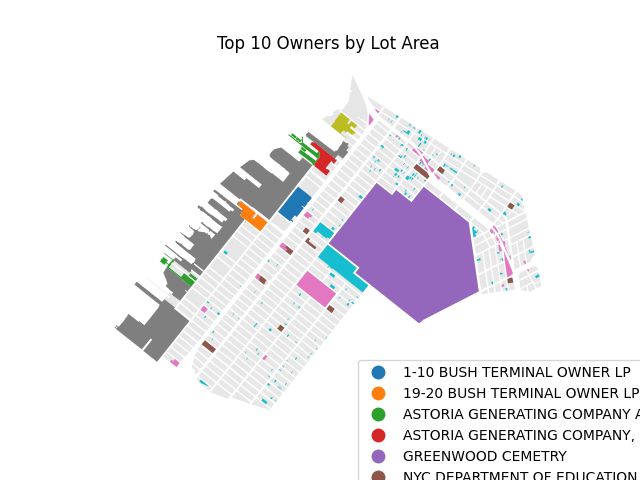

In [44]:
fig, ax = plt.subplots()
cb_307.plot(color="#cecece", ax=ax, alpha=0.5)

cb_307_by_owner.sort_values("LotArea", ascending=False).head(10).plot(
    column="OwnerName", legend=True, ax=ax
).set_axis_off()


# get legend item
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.0, 0.0, 0.5, 0.2))
ax.set_title("Top 10 Owners by Lot Area")
# put legend off the plot
# cb_307_by_owner.plot(column="OwnerName", legend=False)

In [45]:
cb_307_by_owner

OwnerName  \
0           *** NO OWNER FOUND ***   
1      1-10 BUSH TERMINAL OWNER LP   
2              10 E 4TH STREET LLC   
3             10-16 OCEAN REALTIES   
4                  100 19TH STREET   
...                            ...   
12136               ZWERLING, CARA   
12137              ZWICK, ELAINE R   
12138               ZWL REALTY LLC   
12139            ZY MANAGEMENT LLC   
12140          ZYT MANAGEMENT INC.   

                                                geometry  \
0      POLYGON ((980590.724 174235.587, 980527.813 17...   
1      POLYGON ((982202.987 178074.791, 982200.638 17...   
2      POLYGON ((990181.201 176930.755, 990282.152 17...   
3      POLYGON ((991792.749 176633.932, 991787.150 17...   
4      POLYGON ((989711.736 177970.244, 989649.158 17...   
...                                                  ...   
12136  POLYGON ((990576.588 178737.293, 990630.331 17...   
12137  POLYGON ((990085.407 178976.260, 990103.152 17...   
12138  POLYGON ((983015.618 174308.387, 982951.592 17...   
12139  POLYGON ((981487.360 171696.522, 981474.555 17...   
12140  POLYGON ((980899.844 177312.031, 980912.602 17...   

                                                 LandUse  LotArea  
0                           [One & Two Family Buildings]     2003  
1      [Commercial & Office Buildings, Industrial & M...   722097  
2                       [Multi-Family Walk-Up Buildings]     2050  
3                      [Multi-Family Elevator Buildings]    42968  
4                       [Multi-Family Walk-Up Buildings]     6010  
...                                                  ...      ...  
12136                       [One & Two Family Buildings]     2000  
12137                   [Multi-Family Walk-Up Buildings]     2000  
12138                   [Multi-Family Walk-Up Buildings]     2003  
12139         [Mixed Residential & Commercial Buildings]     2017  
12140         [Mixed Residential & Commercial Buildings]     1669  

[12141 rows x 4 columns]

## Intersect / Difference


In [46]:
sample_block = cb_307.Block.sample(1).values[0]

In [47]:
sample_block

697

In [48]:
cb_307_bldgs.columns

Index(['name', 'base_bbl', 'shape_area', 'heightroof', 'mpluto_bbl',
       'cnstrct_yr', 'globalid', 'lststatype', 'feat_code', 'groundelev',
       'geomsource', 'bin', 'lstmoddate', 'doitt_id', 'shape_len', 'geometry',
       'rep_pt'],
      dtype='object')

In [49]:
sample_block_lots = cb_307[cb_307.Block.eq(sample_block)].copy()
sample_block_bldgs = cb_307_bldgs[
    cb_307_bldgs.mpluto_bbl.isin(sample_block_lots.BBL.unique())
].copy()

In [50]:
sample_block_bldgs.set_geometry("geometry", inplace=True)

Text(0.5, 1.0, 'Block 697')

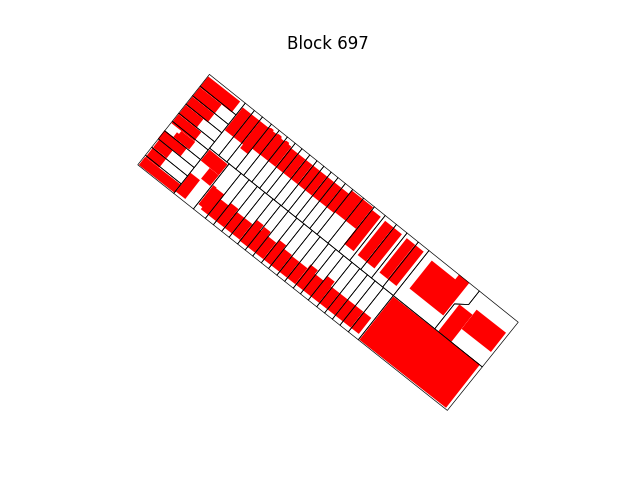

In [51]:
ax = sample_block_lots.boundary.plot(color="black", linewidth=0.5)
sample_block_bldgs.plot(ax=ax, color="red").set_axis_off()

ax.set_title(f"Block {sample_block}")

In [52]:
sample_block_non_bldg = sample_block_lots.difference(sample_block_bldgs.unary_union)

In [53]:
sample_block_non_bldg.shape

(55,)

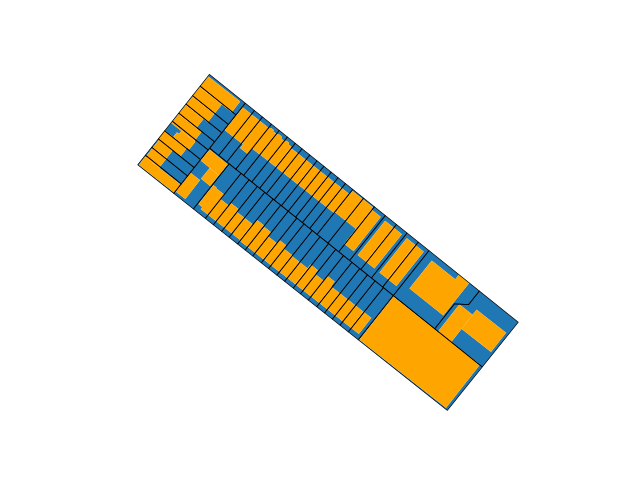

In [54]:
ax = sample_block_lots.boundary.plot(color="black", linewidth=0.5)
sample_block_non_bldg.plot(ax=ax)
sample_block_bldgs.plot(ax=ax, color="orange").set_axis_off()

In [55]:
sample_block_non_bldg_intersect = sample_block_lots.intersection(
    sample_block_bldgs.unary_union
)

In [56]:
sample_block_non_bldg_intersect.shape

(55,)

<Axes: >

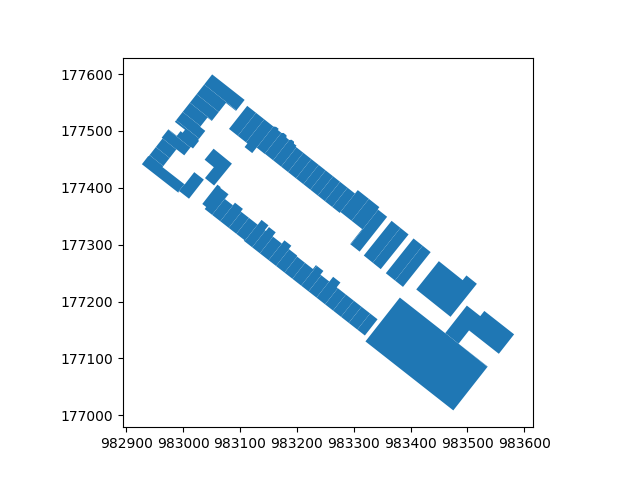

In [57]:
sample_block_non_bldg_intersect.plot()

## Union


In [58]:
sample_block_lots["lot_area"] = sample_block_lots.area

In [59]:
lots_bldgs_union = gpd.overlay(sample_block_lots, sample_block_bldgs, how="union")

In [60]:
lots_bldgs_union.shape

(189, 115)

In [61]:
import pandas as pd

In [62]:
lots_bldgs_union

Borough  Block   Lot     CD  BCT2020    BCTCB2020 CT2010 CB2010  \
0        BK  697.0  25.0  307.0  3008400  30084001002     84   1002   
1        BK  697.0  25.0  307.0  3008400  30084001002     84   1002   
2        BK  697.0  26.0  307.0  3008400  30084001002     84   1002   
3        BK  697.0  26.0  307.0  3008400  30084001002     84   1002   
4        BK  697.0  24.0  307.0  3008400  30084001002     84   1002   
..      ...    ...   ...    ...      ...          ...    ...    ...   
184     NaN    NaN   NaN    NaN      NaN          NaN    NaN    NaN   
185     NaN    NaN   NaN    NaN      NaN          NaN    NaN    NaN   
186     NaN    NaN   NaN    NaN      NaN          NaN    NaN    NaN   
187     NaN    NaN   NaN    NaN      NaN          NaN    NaN    NaN   
188     NaN    NaN   NaN    NaN      NaN          NaN    NaN    NaN   

    SchoolDist  Council  ...   lststatype feat_code  groundelev  geomsource  \
0           15     38.0  ...  Constructed      2100          41  Photogramm   
1           15     38.0  ...  Constructed      2100          41  Photogramm   
2           15     38.0  ...  Constructed      2100          41  Photogramm   
3           15     38.0  ...  Constructed      2100          42  Photogramm   
4           15     38.0  ...  Constructed      2100          41  Photogramm   
..         ...      ...  ...          ...       ...         ...         ...   
184        NaN      NaN  ...  Constructed      2100          27  Photogramm   
185        NaN      NaN  ...  Constructed      2100          46  Photogramm   
186        NaN      NaN  ...  Constructed      2100          50  Photogramm   
187        NaN      NaN  ...  Constructed      2100          31  Photogramm   
188        NaN      NaN  ...  Constructed      2100          40  Photogramm   

         bin lstmoddate doitt_id shape_len                         rep_pt  \
0    3010350 2017-08-22   210271       0.0  POINT (983301.348 177369.258)   
1    3010349 2017-08-22   138436       0.0  POINT (983281.929 177378.283)   
2    3010350 2017-08-22   210271       0.0  POINT (983301.348 177369.258)   
3    3010351 2017-08-22   307967       0.0  POINT (983318.884 177352.318)   
4    3010349 2017-08-22   138436       0.0  POINT (983281.929 177378.283)   
..       ...        ...      ...       ...                            ...   
184  3010334 2017-08-22   706611       0.0  POINT (983050.128 177555.385)   
185  3010356 2017-08-22   119300       0.0  POINT (983403.089 177262.594)   
186  3010361 2017-08-22   480274       0.0  POINT (983309.434 177171.227)   
187  3010328 2017-08-22   454152       0.0  POINT (982958.287 177454.613)   
188  3010347 2017-08-22   241908       0.0  POINT (983259.703 177403.729)   

                                              geometry  
0    POLYGON ((983276.678 177357.472, 983276.595 17...  
1    POLYGON ((983289.106 177400.193, 983302.148 17...  
2    POLYGON ((983307.169 177395.931, 983326.101 17...  
3    POLYGON ((983296.188 177342.063, 983295.681 17...  
4    POLYGON ((983262.215 177366.275, 983261.710 17...  
..                                                 ...  
184  POLYGON ((983039.304 177552.100, 983062.692 17...  
185  POLYGON ((983421.070 177298.231, 983421.070 17...  
186  POLYGON ((983313.712 177190.848, 983306.337 17...  
187  POLYGON ((982940.968 177457.539, 982965.075 17...  
188  POLYGON ((983263.724 177420.240, 983238.650 17...  

[189 rows x 115 columns]

<Axes: >

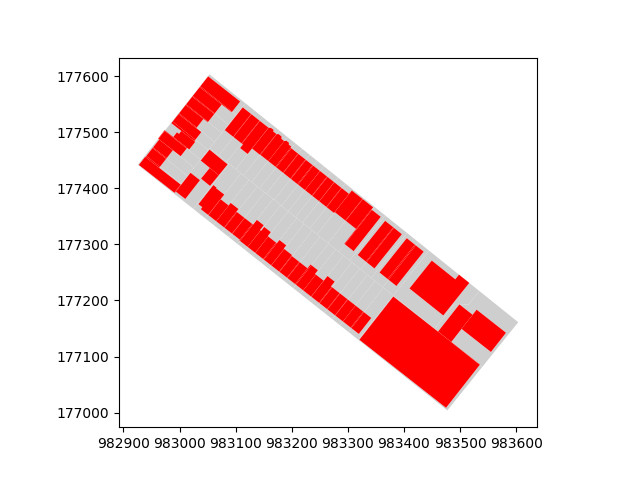

In [63]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot(color="#cecece")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot(ax=ax, color="red")

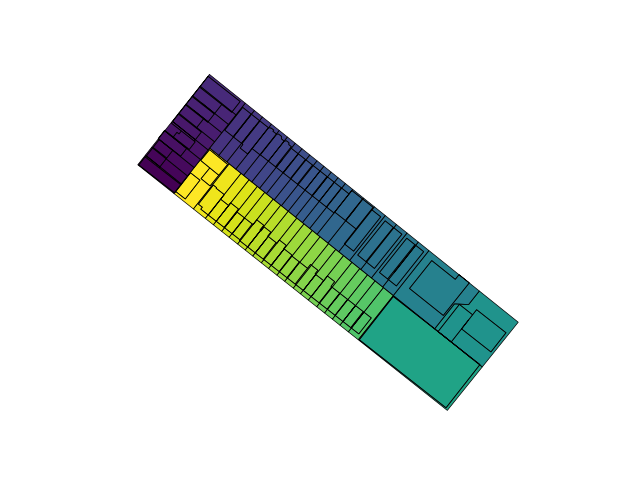

In [64]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot("Lot")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot("Lot", ax=ax)
lots_bldgs_union.boundary.plot(color="black", ax=ax, linewidth=0.5).set_axis_off()

In [65]:
lots_bldgs_union.globalid.unique()

array(['{5A08A8D1-698C-4F86-BE23-FF9719E2123A}',
       '{B9ECF40C-4F3E-4691-AE82-420514004FCE}',
       '{D8DF9244-89A5-4471-9201-5D94350D9384}',
       '{5C80AB3B-767F-43DA-B4DB-860D63951A43}',
       '{5FE25748-4750-451D-B676-C76D834EA434}',
       '{986417A4-EA8E-47D9-9E6F-B705D3516DB5}',
       '{A6C2F3B0-169D-444C-8E95-A60408CFDDC3}',
       '{67545B48-7B85-49B2-B93B-055CD8AF1CB4}',
       '{B8608261-1A6F-4825-AFE7-70B542A907E2}',
       '{75FF4965-224E-4D20-A91C-0E2800F11A82}',
       '{5095FABA-4475-4439-A63B-D5A4C09227CD}',
       '{62CC69BE-EDB5-4468-A57A-79C3009DC7FA}',
       '{CE79B32A-CD80-482D-A1F2-EBE434C4A263}',
       '{17F03842-A797-44E5-8E84-9FEBCD97C618}',
       '{4552E0FE-AB7C-4FF4-858C-7AFADDD4534A}',
       '{BD53497A-8107-4EDD-A767-33FA27937A44}',
       '{A5118D6B-4547-44CD-B58C-6DCE5DE10855}',
       '{7A58AE75-349C-4C4A-A296-85BE10223DB3}',
       '{636256A6-CE7E-4BE5-9672-AD754DF2DD08}',
       '{0334F228-36F8-496A-944F-C3A1A8D89B9E}',
       '{94CD939C-BB

In [66]:
lots_bldgs_union["pct_bldg_lot_coverage"] = lots_bldgs_union.apply(
    lambda x: ((x.geometry.area / x.lot_area) * 100 if type(x.globalid) == str else -1),
    axis=1,
)

<Axes: >

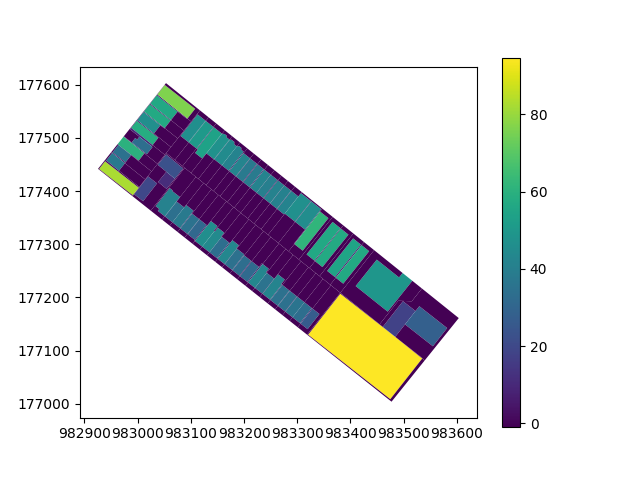

In [67]:
lots_bldgs_union.plot("pct_bldg_lot_coverage", legend=True)

## calculate soft sites (create new attributes)


In [68]:
def is_soft_site(r, threshold=0.33):
    if (
        r.BuiltFAR <= r.ResidFAR * threshold
        and r.LotArea > 10000
        and r.LandUse != "Open Space & Outdoor Recreation"
        and r.ResidFAR > 0
    ):
        return 1
    else:
        return 0

In [69]:
cb_307["soft_site"] = cb_307.apply(is_soft_site, axis=1)

In [70]:
cb_307["soft_site"].value_counts()

soft_site
0    13251
1       33
Name: count, dtype: int64

<Axes: >

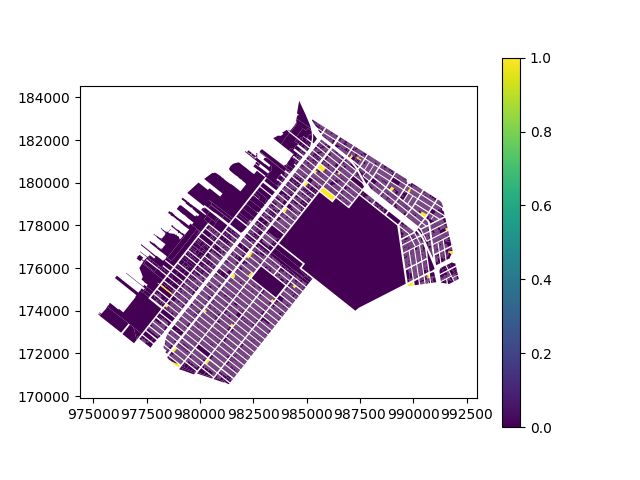

In [71]:
cb_307.plot("soft_site", legend=True)

In [72]:
cb_307[cb_307.soft_site.eq(1)][["soft_site", "BuiltFAR", "ResidFAR"]]

soft_site  BuiltFAR  ResidFAR
116            1      0.05      1.25
125            1      0.69      2.43
529            1      0.18      4.00
538            1      0.59      3.00
796            1      0.41      1.35
1642           1      0.97      6.02
1656           1      0.09      2.00
1696           1      0.00      6.02
1738           1      0.40      2.00
1905           1      0.32      2.00
2383           1      0.54      2.00
2445           1      0.00      2.00
3370           1      0.18      1.35
3456           1      0.00      1.35
4234           1      0.00      2.00
4592           1      0.13      4.00
4992           1      0.00      6.02
5642           1      0.00      2.00
5740           1      0.60      4.00
6046           1      0.59      3.00
6665           1      0.98      4.00
7199           1      0.02      3.00
7669           1      0.00      2.43
8386           1      0.19      4.00
8514           1      0.65      4.00
8515           1      0.22      4.00
8615           1      0.90      3.00
8986           1      0.72      4.00
9443           1      0.38      2.00
9985           1      0.50      3.00
11044          1      0.44      4.00
11676          1      0.54      4.00
12317          1      0.14      1.25